<a href="https://colab.research.google.com/github/bayhaqy/analisa-sentimen/blob/master/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analisis Sentimen tentang Islamophobia

# Install dan import Requirement  yang dibutuhkan

### Install Library

In [0]:
# Install library
!pip install googletrans
!pip install emoji
!pip install joblib
!pip install wordcloud

## Mounting Google Drive

In [0]:
# Mounting Gdrive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### Copy Data dari Google Drive

In [0]:
# cek dir dan copy csv
#!ls /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'
#!pwd

#!cp /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/'dataminer15Maret2019-Gabung.xlsx' /content

!cp /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/'dataminer_islamophobia_15Mar19.xlsx' /content
#!cp /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/'export_data_islamophobia.csv' /content
!cp /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/'export_data_islamophobia1.csv' /content
!cp /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/'export_data_islamophobia2.csv' /content

!cp /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/stop_tambah.txt /content/
!cp /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/emotion.txt /content/
!ls

dataminer_islamophobia_15Mar19.xlsx    mosque.png
emotion.txt			       negative.png
export_data_islamophobia1.csv	       positive.png
export_data_islamophobia2.csv	       sample_data
export_data_islamophobia_pred_new.csv  stop_tambah.txt
gdrive


### Import Library

In [0]:
# untuk decode kata, contoh : 𝓘𝓷𝓭𝓸𝓷𝓮𝓼𝓲𝓪 menjadi indonesia
#from unidecode import unidecode

# untuk analisis dan memanipulasi data
import pandas as pd

# untuk operasi matematika
import numpy as np

# untuk menghitung waktu prediksi
import time

# untuk fungsi regex
import re

# untuk mengambil punctuation data
import string

# untuk translate tweet
from googletrans import Translator

# untuk deteksi emoji
import emoji

# untuk membuat wordcloud
from wordcloud import WordCloud

# untuk membuat plot
import matplotlib.pyplot as plt
import seaborn as sns

# untuk Stemming, Tokenize, Stopword dan Vader
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('punkt')

# untuk encoding data label
from sklearn.preprocessing import LabelEncoder

# untuk TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# untuk K-Fold cross validation
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict

# untuk algoritma naive bayes, svm dan metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report

# untuk mengurutkan matric score
from collections import OrderedDict

# untuk melakukan teknik resampling data yang tidak seimbang dan pipeline
from imblearn.over_sampling import SMOTE
from imblearn import pipeline

# untuk export model
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# Data Preparation

## Data Labeling dan Preprocessing Tahap 1

### Membaca RAW Data dari Data Miner

In [0]:
# Read data
#rawdata = pd.read_excel('dataminer15Maret2019-Gabung.xlsx',dtype=str)
rawdata = pd.read_excel('dataminer_islamophobia_15Mar19.xlsx',dtype=str)

# Cek data
display(rawdata.head())

# Cek attribut dataset
display(rawdata.columns)

# Cek jumlah baris dan kolom dataset
display(rawdata.shape)

# Cek Nilai Null
print(rawdata.isnull().sum())

,UserName,FullName,Date,First Hashtags,Alt Hashtags,Tweet (Message Text),Retweets,Retweets (w/ Text),Likes,Likes (w/ Text),URL Path
0,@SozBoz123,Jake‏ @SozBoz123,15 Mar,NaN,NaN,"Why, today, do we get radio silence compared t...",5 5,Retweet\n \n \n \n \n \n \n ...,NaN,Suka\n \n \n 5\n \n \n \n ...,/SozBoz123/status/1106706629637144577
1,@samboycee,sam‏ @samboycee,15 Mar,#NZMosqueShooting,NaN,this was an act of terrorism. done out of pure...,NaN,Retweet\n \n \n \n \n \n \n ...,NaN,Suka\n \n \n \n \n \n \n ...,/samboycee/status/1106706617893044224
2,@CCUChanticleers,Coastal Carolina U.‏Akun terverifikasi @CCUCha...,15 Mar,#CCU,NaN,The terrible killings committed at the mosques...,1 2 2 7 7,Retweet\n \n \n 2\n \n \n \n ...,NaN,Suka\n \n \n 7\n \n \n \n ...,/CCUChanticleers/status/1106706596212731905
3,@fentytwd,ari‏ @fentytwd,15 Mar,NaN,NaN,it’s crazy how islamophobia is so normalized i...,1 3 3,Retweet\n \n \n \n \n \n \n ...,NaN,Suka\n \n \n 3\n \n \n \n ...,/fentytwd/status/1106706596187570181
4,@JuliusFlywheel @coopesdetat,Julius Flywheel‏ @JuliusFlywheel,15 Mar,NaN,NaN,"Identical in creed, motivation and especially ...",3 3,Retweet\n \n \n \n \n \n \n ...,NaN,Suka\n \n \n 3\n \n \n \n ...,/JuliusFlywheel/status/1106706529409859584


Index(['UserName', 'FullName', 'Date', 'First Hashtags', 'Alt Hashtags',
       'Tweet (Message Text)', 'Retweets', 'Retweets (w/ Text)', 'Likes',
       'Likes (w/ Text)', 'URL Path'],
      dtype='object')

(3115, 11)

UserName                   0
FullName                   0
Date                       0
First Hashtags          1716
Alt Hashtags            2096
Tweet (Message Text)       0
Retweets                1113
Retweets (w/ Text)         0
Likes                   3115
Likes (w/ Text)            0
URL Path                   0
dtype: int64


### Mengambil Hanya Data Tweet

In [0]:
#data= rawdata.filter(['Tweet (Message Text)'])
#data= data.rename(columns={"Tweet (Message Text)": "Tweet"})

file_name = ('export_data_islamophobia2.csv')
data= pd.read_csv(file_name)

# Cek data
display(data.head())

# Cek attribut dataset
display(data.columns)

# Cek jumlah baris dan kolom dataset
display(data.shape)

# Cek Nilai Null
print(data.isnull().sum())

#list(data['Tweet (Message Text)'][:5])

,Tweet,Sentiment
0,a broader view includes endless foreign war a ...,Negative
1,a compelling thread the inequalities fostered ...,Negative
2,a cult founded by a robber murderer rapist ped...,Negative
3,a debate is needed to discuss the term islamop...,Negative
4,a factor here is how quickly islamophobia seep...,Negative


Index(['Tweet', 'Sentiment'], dtype='object')

(2657, 2)

Tweet        0
Sentiment    0
dtype: int64


### Function for Preprocessing

In [0]:
def clean_tweet(tweet):
  # Case folding
  tweet = tweet.lower()
  
  # Cleansing (Remove URL)
  tweet = re.sub('http\S+|\S+co\S+', ' ', tweet)
    
  # Cleansing (Remove Mention)
  tweet = re.sub("@[A-Za-z0-9\S]+", "", tweet)
  
  # Cleansing (Remove Hastag)
  tweet = re.sub(r'#([^\s]+)', r'\1', tweet)
  
  # Cleansing (Convert Emoticon)
  emotion	= [emot.strip('\n').strip('\r') for emot in open('emotion.txt')]
  dic={}
  token = tweet.split()
  for i in emotion:
    (key,val)=i.split('\t')
    dic[str(key)]=val
  tweet = ' '.join(str(dic.get(word, word)) for word in token)
  
  # Cleansing (Remove Number and Punctuation)
  wrem_list = ('rt')
  exclude = set (string.punctuation)
  rem_list = []
  token = tweet.split()
  for w in token:
    if w not in wrem_list:
      for x in w:
        if x in exclude or x.isdigit():
          x=""
          rem_list.append(x)
        else:
          rem_list.append(x)
      rem_list.append(" ")
  tweet = "".join(rem_list)

  # Replace karakter berulang
  def hapus_katadouble(tweet):
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", tweet)
  
  tweet=hapus_katadouble(tweet)
  
  return tweet


# Preprocessing english
def preprocessing_en(tweet):

  # PorterStemmer English dari library NLTK
  stemmer = PorterStemmer()
  #stemmer = WordNetLemmatizer()
  
  # masukkan stopord tambahan
  file = open('stop_tambah.txt')
  stoptambah = file.read()
    
  token_words = word_tokenize(clean_tweet(tweet))
  sentence = []
  for word in token_words:
    if word not in stoptambah and len(word) > 1 and len(word) < 25:   
      sentence.append(stemmer.stem(word))
      #sentence.append(stemmer.lemmatize(word,pos='v'))
  return sentence
  

# Translate ke English menggunakan Google Translate
def gtrans_tweet_en(tweet):
  translator = Translator()
  translator = translator.translate(tweet,dest='en')
  translator = translator.text
  return translator


# Klasifikasi Polaritas Tweet menggunakan Vader
def sentiment_Vader(tweet):
  analysis = SentimentIntensityAnalyzer()
  analysis = analysis.polarity_scores(tweet)
  comm = analysis['compound']
  if (comm >= 0.05):
    return "Positive"
  elif ((comm > -0.05) and (comm < 0.05)):
    return "Neutral"
  else:
    return "Negative"

# Cek analisis sentimen dari English tweet menggunakan VADER
def sentiment_analysis_en(tweet):
  tweet = clean_tweet(tweet)
  translate = Translator().detect(tweet)
  if "en" not in translate.lang:
    tweet = gtrans_tweet_en(tweet)
  sentiment = sentiment_Vader(tweet)
  return sentiment  

# Melakukan cleansing, translate tweet ke  Indonesia dan Preprocessing data
def sentiment_analysis_id(tweet):
  tweet = clean_tweet(tweet)
  translate = Translator().detect(tweet)
  src_lang = translate.lang
  if "id" not in src_lang:
    tweet = gtrans_tweet_id(tweet)
  tweet = preprocessing_id(tweet)
  return tweet

### Labeling untuk Sentiment Analysis hasil dari Veder

In [0]:
# Membuat Tweets setelah cleansing
#data['Cleansing_Tweet'] = data['Tweet'].apply(lambda x: str(clean_tweet(clean_tweet(x))))
#data['Cleansing_Tweet_en'][3000:3114] = data['Cleansing_Tweet'][3000:3114].apply(lambda x: str(gtrans_tweet_en(x)))
#data['Preprocessing_Tweet_en'] = data['Cleansing_Tweet_en'].apply(lambda x: str(preprocessing_en(x)))
#data['Tweet'] = np.array([gtrans_tweet(tweet) for tweet in data['Tweets']])

# Membuat column sentiment Vader
#data['Sentiment'] = data['Cleansing_Tweet_en'].apply(lambda x: str(sentiment_Vader(x)))
#data['Sentiment'] = np.array([sentiment_analysis_Vader(tweet) for tweet in data['Tweets']])

#skip 410
# Sort DataFrame berdasarkan values
#data.sort_values("Cleansing_Tweet_en", ascending=True, inplace = True)
#data.sort_index(ascending=True)
#data = data.reset_index(drop=True)

# Hapus duplicate row di DataFrame
#data.drop_duplicates(subset ="Cleansing_Tweet_en",keep=False,inplace=True) 

# Hapus salah satu row dataframe
#data.drop(['Sentiment'],axis=1,inplace=True)
#data = data.dropna(subset=['Cleansing_Tweet'])

# Tampilkan dataframe
#Display the DataFrame with updated score
#display(data['Tweet'][:100])
#display(data[data['Sentiment_Vader'] == 'Positive'])
display(data)
# Cek jumlah baris dan kolom dataset
display(data.shape)
#list(data['Cleansing_Tweet'][:1])
#display(data[0:3200])

,Tweet,Sentiment
0,a broader view includes endless foreign war a ...,Negative
1,a compelling thread the inequalities fostered ...,Negative
2,a cult founded by a robber murderer rapist ped...,Negative
3,a debate is needed to discuss the term islamop...,Negative
4,a factor here is how quickly islamophobia seep...,Negative
5,a few books to counter islamophobia this list ...,Positive
6,a few more academics on twitter who tweetwrite...,Negative
7,a film that talks about the concept of islamop...,Negative
8,a gay woman walks into a mosque shes greeted w...,Positive
9,a genius hour islamophobia project became the ...,Positive


(2657, 2)

Total Positive       : 642
Total Negative       : 2015
Total Neutral        : 0
Total Data           : 2657



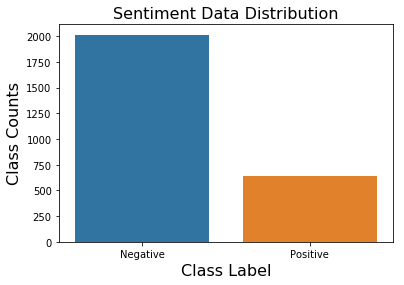

In [0]:
# Cek jumlah positive, negative dan neutral
positives = data[data['Sentiment'] == 'Positive']
negatives = data[data['Sentiment'] == 'Negative']
neutral = data[data['Sentiment'] == 'Neutral']

print('Total Positive       : {}'.format(len(positives)))
print('Total Negative       : {}'.format(len(negatives)))
print('Total Neutral        : {}'.format(len(neutral)))
print('Total Data           : {}'.format(data.shape[0]))
print('')

# Melihat hasil distribusi sentimen menggunakan vader
sns.countplot(x='Sentiment', data=data)
plt.title('Sentiment Data Distribution', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='horizontal');

### Export DataFrame dan Copy ke Google Drive 

In [0]:
# Export Data
#loc_data = ('export_data_islamophobia1.csv')
#export_data = data.to_csv (loc_data, index=False, header=True, encoding='utf-8')
#export_data

# Copy ke Gdrive
#!ls
#!pwd
#!cp export_data_islamophobia1.csv /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/
#!ls /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/

In [0]:
# Melihat contoh data di csv
!cat -n export_data_islamophobia.csv|head -10

cat: export_data_islamophobia.csv: No such file or directory


## Data Preprocessing Tahap 2

### Mengambil 2-class untuk pengujian yaitu Positive dan Negative serta menganalisanya

In [0]:
# Mengambil data Sentimen Positive dan Negative masing-masing 450 menggunakan under-sampling
#t_1 = data[data['Sentiment']=='Positive']#.sample(450)
#t_2 = data[data['Sentiment']=='Negative']#.sample(450)

# Mengambil data Sentimen Positive dan Negative masing-masing 450 menggunakan random under-sampling
t_1 = data[data['Sentiment']=='Positive']#.sample(450,replace=True)
t_2 = data[data['Sentiment']=='Negative']#.sample(450,replace=True)
df = pd.concat([t_1, t_2])

### Menganalisa data

In [0]:
# Mengecek perbandingan total row sebelum dan sesudah difilter
print (data.shape)
print (df.shape)

(2657, 2)
(2657, 2)


Nilai Null:
Tweet        0
Sentiment    0
dtype: int64

Total positive      : 642
Total negative      : 2015
total data          : 2657



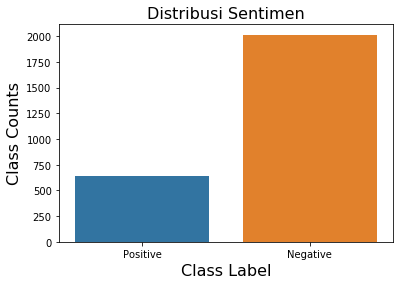

In [0]:
# Cek nilai Null pada data
print('Nilai Null:')
print (df.isnull().sum())
print("")


# Cek jumlah positive, negative dan neutral
positives = df[df['Sentiment'] == 'Positive']
negatives = df[df['Sentiment'] == 'Negative']

print('Total positive      : {}'.format(len(positives)))
print('Total negative      : {}'.format(len(negatives)))
print('total data          : {}'.format(df.shape[0]))
print('')

# Mengecek distribusi sentimen pada dataframe baru
sns.countplot(x='Sentiment', data=df)
plt.title('Distribusi Sentimen', fontsize=16)
plt.ylabel('Class Counts', fontsize=16)
plt.xlabel('Class Label', fontsize=16)
plt.xticks(rotation='horizontal');

In [0]:
# Sort DataFrame berdasarkan values
df.sort_values("Tweet", ascending=True, inplace = True)
#df.sort_values("Cleansing_Tweet", ascending=True, inplace = True)
#df['Tweet'] = df['Cleansing_Tweet_en']
#df.drop(['Cleansing_Tweet_en'],axis=1,inplace=True)
df=df.reset_index(drop=True)
df.head()

,Tweet,Sentiment
0,a broader view includes endless foreign war a ...,Negative
1,a compelling thread the inequalities fostered ...,Negative
2,a cult founded by a robber murderer rapist ped...,Negative
3,a debate is needed to discuss the term islamop...,Negative
4,a factor here is how quickly islamophobia seep...,Negative


### Export & Import DataFrame

In [0]:
# Export Data
#loc_data = ('export_data_islamophobia2.csv')
#export_data = df.to_csv (loc_data, index=False, header=True, encoding='utf-8')
#export_data

# Copy ke Gdrive
#!ls
#!pwd
#!cp export_data_islamophobia2.csv /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/
#!ls /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/

In [0]:
# import dataset
#!cp /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/'export_data_islamophobia_new3.csv' /content
#file_name = ('export_data_islamophobia_new3.csv')
#file_name = 'Dataset Twitter Islamophobia Indo.csv'
#df= pd.read_csv(file_name)


### Membuat object baru untuk dianalisa

In [0]:
# Buat object baru untuk di analisa
X = df.iloc[:, 0].values

# Encode Data Label agar bisa diproses algoritma
le = LabelEncoder()
le.fit(["Positive", "Negative"])

print(list(le.classes_))
y = le.transform(df['Sentiment'])

# Mengecek contoh hasil column baru
#print(X.shape)
#print(y.shape)
print(X[10])
print(y[0])
print(X.dtype)
print(y.dtype)

['Negative', 'Positive']
a great piece by on how prevalent islamophobia is in the highest echelons of american political life when i read the manifesto of the new zealand mass shooter i couldnt help but think of highprofile american politicians such as the president of the united states who said islam hates us writes 
0
object
int64


### Proses TF-IDF

In [0]:
# Melakukan proses TF-IDF
t0_tfidf = time.time()
tfidfconverter = TfidfVectorizer(min_df=2, max_df=0.7, ngram_range=(1,3), stop_words = word_tokenize('english'), tokenizer=preprocessing_en)
X_vect = tfidfconverter.fit_transform(X).toarray()
t1_tfidf = time.time()
time_tfidf = t1_tfidf-t0_tfidf

print("TF-IDF time: %fs" % (time_tfidf))
X_vect.shape

TF-IDF time: 2.879469s


(2657, 6950)

# Data Modeling

### Tabel Confusion Matrix

In [0]:
# Plot Confusion Matrix
def conf_matrix(cm):
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
  classNames = ['Negative','Positive']
  plt.title('Confusion Matrix - Test Data Positive dan Negative')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  tick_marks = np.arange(len(classNames))
  plt.xticks(tick_marks, classNames, rotation=45)
  plt.yticks(tick_marks, classNames)
  s = [['TN','FP'], ['FN', 'TP']]
  for i in range(2):
      for j in range(2):
          plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
  plt.show()

### ROC Curve

In [0]:
def roccurve(Y, y_pred):
  fpr, tpr, thresholds = roc_curve(Y, y_pred)
  roc_auc = auc(fpr,tpr)
  plt.plot(fpr, tpr, 'b',label='AUC = %0.3f'% roc_auc)
  plt.plot([0,1],[0,1],'k--')
  plt.xlim([0.0,1.0])
  plt.ylim([0.0,1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')
  
  # create the axis of thresholds (scores)
  ax2 = plt.gca().twinx()
  ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
  ax2.set_ylabel('Threshold',color='r')
  ax2.set_ylim([thresholds[-1],thresholds[0]])
  ax2.set_xlim([fpr[0],fpr[-1]])
  plt.show()

### Cross Validation

In [0]:
def kfoldcv(classifier, X, Y, folds, print_all_scores=False, timed=True):

    # memulai timer
    mulai_time = time.time()

    # untuk mengecek feature matrix dan vector label  dengan format ndarray untuk mencegah masalah saat scalar indexing
    if type(X) is not np.ndarray:
        X = np.array(X)
    if type(Y) is not np.ndarray:
        Y = np.array(Y)

    # membuat dictionary untuk score
    scores=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    values = [np.array([]) for i in range(0, len(scores))]
    dict_score = OrderedDict(zip(scores, values))

    # menghitung score
    dict_score['accuracy'] = np.append(dict_score['accuracy'],cross_val_score(classifier, X, Y, scoring='accuracy', cv=folds))
    dict_score['precision']  = np.append(dict_score['precision'],cross_val_score(classifier, X, Y, scoring='precision', cv=folds))
    dict_score['recall'] = np.append(dict_score['recall'],cross_val_score(classifier, X, Y, scoring='recall', cv=folds))
    dict_score['f1'] = np.append(dict_score['f1'],cross_val_score(classifier, X, Y, scoring='f1', cv=folds))
    dict_score['roc_auc'] = np.append(dict_score['roc_auc'],cross_val_score(classifier, X, Y, scoring='roc_auc', cv=folds))

    y_pred = cross_val_predict(classifier, X, Y, cv=folds)
    cm = confusion_matrix(Y, y_pred)

    # print semua hasil score cross validation
    if print_all_scores:
        for score_name, scores in dict_score.items():
            print ("%s: %s" % (score_name, scores))

    # print hasil rata-rata score cross validation
    for score_name, scores in dict_score.items():
        print ("%s: %0.3f (+/- %0.3f)" % (score_name, scores.mean(), 2*scores.std()))

    # print waktu yang dibutuhkan untuk komputasi
    if timed:
        print ("Waktu yang dibutuhkan: %0.2fmins." % ((time.time() - mulai_time)/60))
    
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    Totaldata = TN+FP+FN+TP
    Accuracy = ((TP + TN) / (TP + TN + FN + FP))
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN))
    F1 = (2 * (Precision * Recall) / (Precision + Recall))
    
    TPRate = Recall
    TNRate = (TN / (TN + FP))
    AUC = ((Recall + TNRate)/2)
    
    print("Confusion Matrix - Hitung Manual")
    print("TN %s FP %s" % (TN,FP))
    print("FN %s TP %s" % (FN,TP))
    print("Total data: %s" % (Totaldata))
    print("Accuracy  : %0.3f %%" % (Accuracy*100))
    print("Precision : %0.3f %%" % (Precision*100))
    print("Recall    : %0.3f %%" % (Recall*100))
    print("F1-Score  : %0.3f %%" % (F1*100))
    print("ROC-AUC   : %0.3f %%" % (AUC*100))
    conf_matrix(cm)
    print(classification_report(Y, y_pred))
    print("")
    print('Total Data Prediksi Negative ',sum(y_pred == 0))
    print('Total Data Prediksi Positive ',sum(y_pred == 1))
    print('Total Data Negative ',sum(Y == 0))
    print('Total Data Positive ',sum(Y == 1))
    print('Total Data ',len(Y))
    print("")    
    roccurve(Y,y_pred)
    
    #df_tfidf = pd.DataFrame(X,columns=tfidfconverter.get_feature_names())
    #df_tfidf['Sentiment'] = le.inverse_transform(Y)
    #df_tfidf['Sentiment_Pred'] = le.inverse_transform(y_pred)
        
    # export model
    #classifier.fit(X,Y)
    #pickle.dump(classifier, open('model1.pkl','wb'))
    # Copy ke Gdrive
    #!cp model1.pkl /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/
    #!ls /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/

### Cross Validation + SMOTE

In [0]:
def kfoldcv_SMOTE(classifier, X, Y, folds, print_all_scores=False, timed=True):
    
    # memulai timer
    mulai_time = time.time()

    # untuk mengecek feature matrix dan vector label  dengan format ndarray untuk mencegah masalah saat scalar indexing
    if type(X) is not np.ndarray:
        X = np.array(X)
    if type(Y) is not np.ndarray:
        Y = np.array(Y)

    # membuat dictionary untuk score
    scores=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    values = [np.array([]) for i in range(0, len(scores))]
    dict_score = OrderedDict(zip(scores, values))

    # Penggunaan SMOTEE
    sm_combine = SMOTE(sampling_strategy='minority',random_state=10)
    #sm_combine = SMOTEENN(enn=EditedNearestNeighbours(),random_state=2,ratio='auto',smote=SMOTE())

    Total_Y0 = sum(Y == 0)
    Total_Y1 = sum(Y == 1)
    X, Y = sm_combine.fit_sample(X, Y)
    
    classifier = pipeline.make_pipeline(sm_combine,classifier)
    
    # menghitung score
    dict_score['accuracy'] = np.append(dict_score['accuracy'],cross_val_score(classifier, X, Y, scoring='accuracy', cv=folds))
    dict_score['precision']  = np.append(dict_score['precision'],cross_val_score(classifier, X, Y, scoring='precision', cv=folds))
    dict_score['recall'] = np.append(dict_score['recall'],cross_val_score(classifier, X, Y, scoring='recall', cv=folds))
    dict_score['f1'] = np.append(dict_score['f1'],cross_val_score(classifier, X, Y, scoring='f1', cv=folds))
    dict_score['roc_auc'] = np.append(dict_score['roc_auc'],cross_val_score(classifier, X, Y, scoring='roc_auc', cv=folds))

    y_pred = cross_val_predict(classifier, X, Y, cv=folds)
    cm = confusion_matrix(Y, y_pred)
    
    # print semua hasil score cross validation
    if print_all_scores:
        for score_name, scores in dict_score.items():
            print ("%s: %s" % (score_name, scores))

    # print hasil rata-rata score cross validation
    for score_name, scores in dict_score.items():
        print ("%s: %0.3f (+/- %0.3f)" % (score_name, scores.mean(), 2*scores.std()))

    # print waktu yang dibutuhkan untuk komputasi
    if timed:
        print ("Waktu yang dibutuhkan: %0.2fmins." % ((time.time() - mulai_time)/60))
    
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    Totaldata = TN+FP+FN+TP
    Accuracy = ((TP + TN) / (TP + TN + FN + FP))
    Precision = (TP / (TP + FP))
    Recall = (TP / (TP + FN))
    F1 = (2 * (Precision * Recall) / (Precision + Recall))
    
    TPRate = Recall
    TNRate = (TN / (TN + FP))
    AUC = ((Recall + TNRate)/2)
    
    print("Confusion Matrix - Hitung Manual")
    print("TN %s FP %s" % (TN,FP))
    print("FN %s TP %s" % (FN,TP))
    print("Total data: %s" % (Totaldata))
    print("Accuracy  : %0.3f %%" % (Accuracy*100))
    print("Precision : %0.3f %%" % (Precision*100))
    print("Recall    : %0.3f %%" % (Recall*100))
    print("F1-Score  : %0.3f %%" % (F1*100))
    print("ROC-AUC   : %0.3f %%" % (AUC*100))
    conf_matrix(cm)
    print(classification_report(Y, y_pred))
    print("")
    print('Total Data Negative sebelum SMOTE ',Total_Y0)
    print('Total Data Positive sebelum SMOTE ',Total_Y1)
    print('Total Data sebelum SMOTE ',Total_Y0+Total_Y1)
    print("")
    print('Total Data Prediksi Negative ',sum(y_pred == 0))
    print('Total Data Prediksi Positive ',sum(y_pred == 1))
    print('Total Data Negative sesudah SMOTE ',sum(Y == 0))
    print('Total Data Positive sesudah SMOTE ',sum(Y == 1))
    print('Total Data sesudah SMOTE ',len(Y))
    print("")
    roccurve(Y,y_pred)

    #df_tfidf = pd.DataFrame(X,columns=tfidfconverter.get_feature_names())
    #df_tfidf['Sentiment'] = le.inverse_transform(Y)
    #df_tfidf['Sentiment_Pred'] = le.inverse_transform(y_pred)
    
    # export model
    #classifier.fit(X,Y)
    #pickle.dump(classifier, open('modelsmote.pkl','wb'))
    # Copy ke Gdrive
    #!cp modelsmote.pkl /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/
    #!ls /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/

### Algoritma

In [0]:
def algo_nb():
  clr_nb = GaussianNB()  
  return clr_nb

def algo_svm():
  clr_svm = LinearSVC(C=3.0)
  return clr_svm

# Evaluasi Hasil Pengujian dan Validasi Model

### Cek Performa

Algoritma Naive Bayes
accuracy: 0.731 (+/- 0.034)
precision: 0.425 (+/- 0.104)
recall: 0.312 (+/- 0.124)
f1: 0.357 (+/- 0.103)
roc_auc: 0.588 (+/- 0.051)
Waktu yang dibutuhkan: 0.32mins.
Confusion Matrix - Hitung Manual
TN 1743 FP 272
FN 442 TP 200
Total data: 2657
Accuracy  : 73.128 %
Precision : 42.373 %
Recall    : 31.153 %
F1-Score  : 35.907 %
ROC-AUC   : 58.827 %


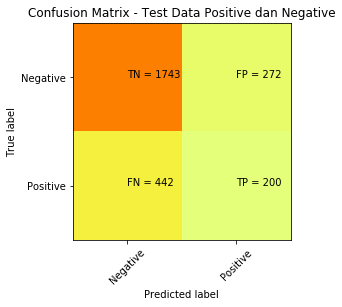

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      2015
           1       0.42      0.31      0.36       642

    accuracy                           0.73      2657
   macro avg       0.61      0.59      0.59      2657
weighted avg       0.71      0.73      0.72      2657


Total Data Prediksi Negative  2185
Total Data Prediksi Positive  472
Total Data Negative  2015
Total Data Positive  642
Total Data  2657



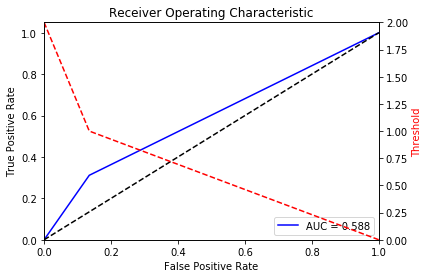

___________________________________________________________
Algoritma Support Vector Machine
accuracy: 0.814 (+/- 0.046)
precision: 0.646 (+/- 0.114)
recall: 0.503 (+/- 0.161)
f1: 0.564 (+/- 0.135)
roc_auc: 0.840 (+/- 0.064)
Waktu yang dibutuhkan: 0.12mins.
Confusion Matrix - Hitung Manual
TN 1839 FP 176
FN 319 TP 323
Total data: 2657
Accuracy  : 81.370 %
Precision : 64.729 %
Recall    : 50.312 %
F1-Score  : 56.617 %
ROC-AUC   : 70.789 %


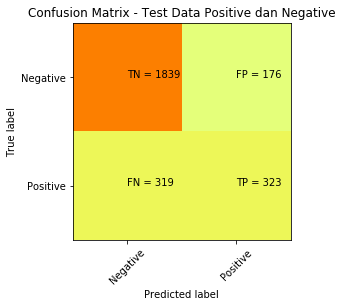

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      2015
           1       0.65      0.50      0.57       642

    accuracy                           0.81      2657
   macro avg       0.75      0.71      0.72      2657
weighted avg       0.80      0.81      0.81      2657


Total Data Prediksi Negative  2158
Total Data Prediksi Positive  499
Total Data Negative  2015
Total Data Positive  642
Total Data  2657



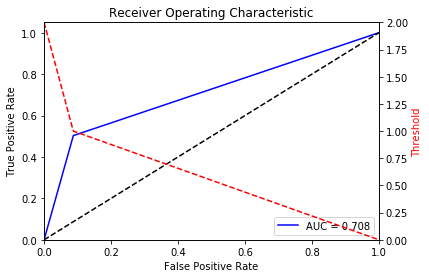

___________________________________________________________
Algoritma Naive Bayes + SMOTEE
accuracy: 0.908 (+/- 0.031)
precision: 0.857 (+/- 0.027)
recall: 0.981 (+/- 0.057)
f1: 0.915 (+/- 0.031)
roc_auc: 0.909 (+/- 0.031)
Waktu yang dibutuhkan: 0.68mins.
Confusion Matrix - Hitung Manual
TN 1684 FP 331
FN 38 TP 1977
Total data: 4030
Accuracy  : 90.844 %
Precision : 85.659 %
Recall    : 98.114 %
F1-Score  : 91.464 %
ROC-AUC   : 90.844 %


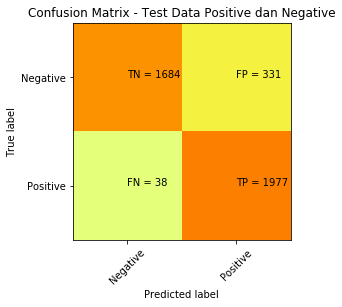

              precision    recall  f1-score   support

           0       0.98      0.84      0.90      2015
           1       0.86      0.98      0.91      2015

    accuracy                           0.91      4030
   macro avg       0.92      0.91      0.91      4030
weighted avg       0.92      0.91      0.91      4030


Total Data Negative sebelum SMOTE  2015
Total Data Positive sebelum SMOTE  642
Total Data sebelum SMOTE  2657

Total Data Prediksi Negative  1722
Total Data Prediksi Positive  2308
Total Data Negative sesudah SMOTE  2015
Total Data Positive sesudah SMOTE  2015
Total Data sesudah SMOTE  4030



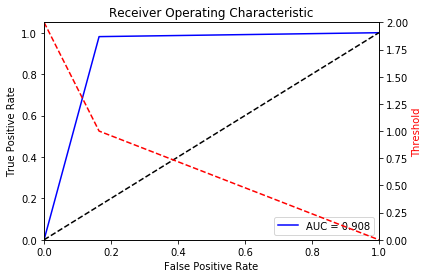

___________________________________________________________
Algoritma Support Vector Machine + SMOTEE
accuracy: 0.914 (+/- 0.033)
precision: 0.861 (+/- 0.037)
recall: 0.987 (+/- 0.037)
f1: 0.920 (+/- 0.031)
roc_auc: 0.978 (+/- 0.022)
Waktu yang dibutuhkan: 0.36mins.
Confusion Matrix - Hitung Manual
TN 1694 FP 321
FN 26 TP 1989
Total data: 4030
Accuracy  : 91.390 %
Precision : 86.104 %
Recall    : 98.710 %
F1-Score  : 91.977 %
ROC-AUC   : 91.390 %


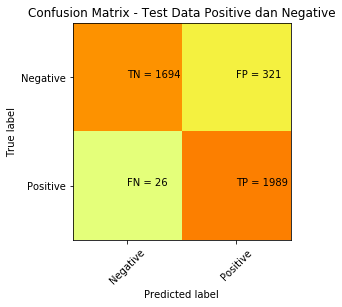

              precision    recall  f1-score   support

           0       0.98      0.84      0.91      2015
           1       0.86      0.99      0.92      2015

    accuracy                           0.91      4030
   macro avg       0.92      0.91      0.91      4030
weighted avg       0.92      0.91      0.91      4030


Total Data Negative sebelum SMOTE  2015
Total Data Positive sebelum SMOTE  642
Total Data sebelum SMOTE  2657

Total Data Prediksi Negative  1720
Total Data Prediksi Positive  2310
Total Data Negative sesudah SMOTE  2015
Total Data Positive sesudah SMOTE  2015
Total Data sesudah SMOTE  4030



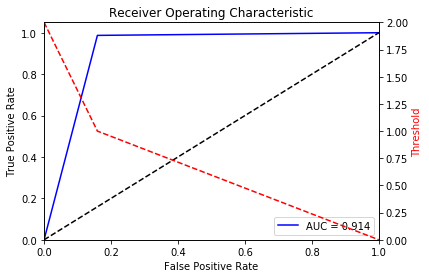

___________________________________________________________


In [0]:
print("Algoritma Naive Bayes")
kfoldcv(classifier=algo_nb(), X=X_vect, Y=y, folds=10)
print('___________________________________________________________')

print("Algoritma Support Vector Machine")
kfoldcv(classifier=algo_svm(), X=X_vect, Y=y, folds=10)
print('___________________________________________________________')

print("Algoritma Naive Bayes + SMOTEE")
kfoldcv_SMOTE(classifier=algo_nb(), X=X_vect, Y=y, folds=10)
print('___________________________________________________________')

print("Algoritma Support Vector Machine + SMOTEE")
kfoldcv_SMOTE(classifier=algo_svm(), X=X_vect, Y=y, folds=10)
print('___________________________________________________________')

### Melihat Total Feature TF-IDF

In [0]:
# Cek semua feature
print(tfidfconverter.get_feature_names())
# Melihat total feature dari yang terbesar
words = pd.DataFrame.from_dict(tfidfconverter.vocabulary_,orient='index',columns=['Count'])
words.sort_values('Count',ascending=False)[:5]

['abandon', 'abject', 'ableism', 'abolish', 'abort', 'abottabad', 'abottabad pakistan', 'abottabad pakistan son', 'abroad', 'abroad stand', 'abroad stand stand', 'absolut', 'absolut sicken', 'absolv', 'absurd', 'abus', 'abus drove', 'abus independ', 'abus muslim', 'abus muslim attack', 'abus spider', 'academ', 'acceler', 'accept', 'accept foundat', 'accept foundat premis', 'accept intoler', 'accept intoler muslim', 'accept limit', 'accept simpli', 'accept simpli truth', 'accept underpin', 'accept underpin attack', 'accid', 'accid zealand', 'accid zealand terror', 'accid zealand terrorist', 'accus', 'accus spectat', 'ach', 'ach happen', 'ach happen commun', 'achiev', 'acknowledg', 'acknowledg kind', 'acknowledg kind fanat', 'act', 'act hatr', 'act terror', 'act vigil', 'act vigil fester', 'act violenc', 'action', 'action gov', 'action gov matter', 'action honor', 'action serb', 'action should', 'activ', 'activ fight', 'activ promot', 'activ shooter', 'activist', 'ad', 'address', 'admini

,Count
zionist kill palestin,6949
zionist kill,6948
zionist,6947
zeland,6946
zealandth horrif terrorist,6945


In [0]:
# Mengecek bobot kata dari TF-IDF
df_tfidf = pd.DataFrame(X_vect,columns=tfidfconverter.get_feature_names())
df_tfidf['Sentiment']= y
df_tfidf.head()

,abandon,abject,ableism,abolish,abort,abottabad,abottabad pakistan,abottabad pakistan son,abroad,abroad stand,abroad stand stand,absolut,absolut sicken,absolv,absurd,abus,abus drove,abus independ,abus muslim,abus muslim attack,abus spider,academ,acceler,accept,accept foundat,accept foundat premis,accept intoler,accept intoler muslim,accept limit,accept simpli,accept simpli truth,accept underpin,accept underpin attack,accid,accid zealand,accid zealand terror,accid zealand terrorist,accus,accus spectat,ach,...,zealand muslim,zealand muslim anchor,zealand muslim commun,zealand muslim ident,zealand muslim unsaf,zealand nation,zealand peac,zealand peopl,zealand peopl faith,zealand polic,zealand power,zealand pray,zealand prime,zealand prime minist,zealand rip,zealand shoot,zealand shoot christchurch,zealand shoot zealand,zealand shooter,zealand stand,zealand stand door,zealand stand solidar,zealand terror,zealand terror attack,zealand terror zealand,zealand terrorist,zealand terrorist attack,zealand white,zealand white supremaci,zealand world,zealand yesterday,zealand zealand,zealandth,zealandth horrif,zealandth horrif terrorist,zeland,zionist,zionist kill,zionist kill palestin,Sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [0]:
words = df_tfidf.drop(['Sentiment'], axis=1).sum(axis=0).sort_values(ascending=False)
words = pd.DataFrame({'Count': words}).reset_index()
words.head()

,index,Count
0,muslim,86.725117
1,attack,56.688560
2,white,53.842662
3,christchurch,52.352109
4,terrorist,50.511334


In [0]:
# Cek prediction text NB dan SVM
y_pred_nb = cross_val_predict(algo_nb(), X_vect, y, cv=10)
y_pred_svm = cross_val_predict(algo_svm(), X_vect, y, cv=10)
df_pred = pd.DataFrame(X,columns=['Tweet'])
df_pred['Cleansing'] = X_vectnew=tfidfconverter.inverse_transform(X_vect)
df_pred['Sentiment'] = le.inverse_transform(y)
df_pred['NB Sentiment'] = le.inverse_transform(y_pred_nb)
df_pred['SVM Sentiment'] = le.inverse_transform(y_pred_svm)
df_pred.tail()

,Tweet,Cleansing,Sentiment,NB Sentiment,SVM Sentiment
2652,your point we had our own mosque shooting in c...,"[boundari, case, christchurch, embolden, fear,...",Negative,Negative,Negative
2653,youre also part of the problem as this comment...,"[better, call, comment, control, countri, figh...",Negative,Negative,Negative
2654,youre spreading islamophobia too because no yo...,"[bad, clearli, feel, feel bad, muslim, muslim ...",Negative,Negative,Negative
2655,youve recently displayed your own brand of isl...,"[brand, display, fathom, fathom pure, fathom p...",Negative,Negative,Negative
2656,youve repeatedly claimed that islamophobia is ...,"[claim, friendli, islamophob, isnt, nationalis...",Positive,Negative,Negative


In [0]:
# Export Data
loc_data = ('export_data_islamophobia_pred_new.csv')
export_data = df_pred.to_csv (loc_data, index=False, header=True, encoding='utf-8')
export_data

# Copy ke Gdrive
#!ls
#!pwd
!cp export_data_islamophobia_pred_new.csv /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/
#!ls /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/

In [0]:
# SMOTE dataset
sm_combine = SMOTE(sampling_strategy='minority', random_state=10)
X_sm, Y_sm = sm_combine.fit_sample(X_vect, y)

In [0]:
# Cek prediction text NB+SMOTE
classifier_nbs = pipeline.make_pipeline(sm_combine,algo_nb())
y_pred_nbs = cross_val_predict(classifier_nbs, X_sm, Y_sm, cv=10)
y_pred_nbs = le.inverse_transform(y_pred_nbs)
values_pred_nbs = ','.join(str(v) for v in y_pred_nbs)
print(values_pred_nbs)

# Cek prediction text SVM+SMOTE
classifier_svm = pipeline.make_pipeline(sm_combine,algo_svm())
y_pred_svm = cross_val_predict(classifier_svm, X_sm, Y_sm, cv=10)
y_pred_svm = le.inverse_transform(y_pred_svm)
values_pred_svms = ','.join(str(v) for v in y_pred_svm)
print(values_pred_svms)

# Cek label VADER setelah smote
Y_new = le.inverse_transform(Y_sm)
values_pred_smote = ','.join(str(v) for v in Y_new)
print(values_pred_smote)

# Cek tweet setelah smote
X_new=tfidfconverter.inverse_transform(X_sm)
values_X = ','.join(str(v) for v in X_new)
print(values_X)

Negative,Negative,Negative,Negative,Negative,Positive,Negative,Positive,Negative,Positive,Positive,Negative,Negative,Positive,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Positive,Positive,Negative,Negative,Positive,Negative,Positive,Negative,Positive,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Positive,Negative,Negative,Positive,Negative,Positive,Positive,Positive,Negative,Negative,Positive,Negative,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Positive,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Positive,Positive,Negative,Negative,Negative,Negative,Negative,Positive,Negative,Negative,Positive,Negative,Positive,Negative,Positive,Positive,Negative,Positive,Negative,Positive,Positive,Positive,Negative,Negative,Negative,Negative,Positive,Positive,N

In [0]:
# Melihat frekuensi kata terbanyak pada masing-masing sentiment class
for i in range(2):
  word_freq_class = df_tfidf[(df_tfidf['Sentiment']==i).values]
  word_freq_class_drop = word_freq_class.drop(['Sentiment'], axis=1).sum(axis=0)
  order_word_freq_class_drop = word_freq_class_drop.sort_values(ascending=False)
  print('Frekuensi kata untuk class sentimen '+ str(i))
  print(order_word_freq_class_drop[:5])

Frekuensi kata untuk class sentimen 0
muslim       69.644461
attack       53.782602
terrorist    48.309486
terror       46.286288
white        41.935367
dtype: float64
Frekuensi kata untuk class sentimen 1
muslim          17.080657
love            13.260643
white           11.907295
christchurch    11.091320
dont            10.465032
dtype: float64


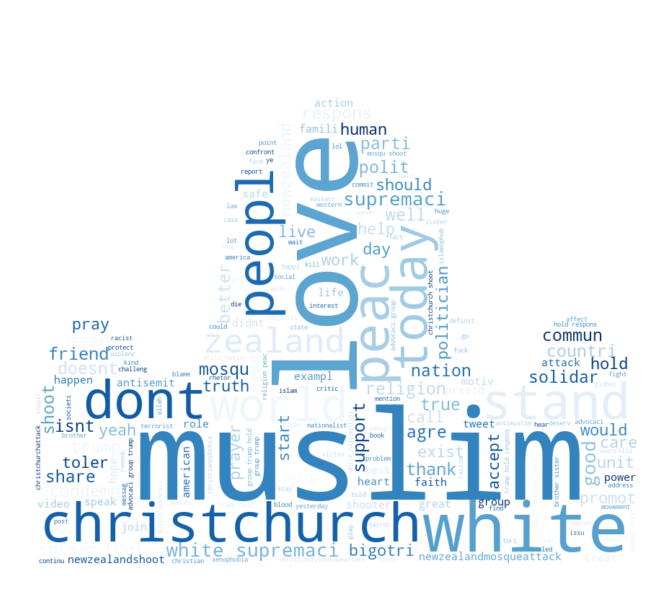

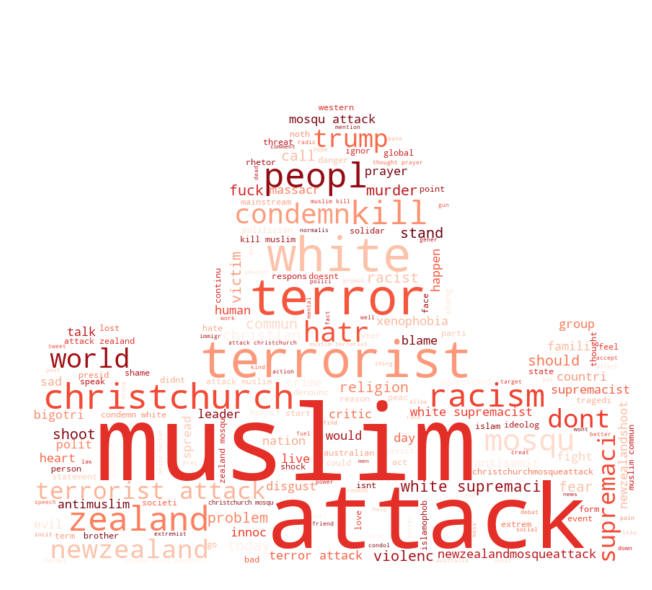

In [0]:
from PIL import Image

allwords = df_tfidf.drop(['Sentiment'], axis=1).sum(axis=0).sort_values(ascending=False)
pos_allwords = df_tfidf[(df_tfidf['Sentiment']==1).values].drop(['Sentiment'], axis=1).sum(axis=0).sort_values(ascending=False)
neg_allwords = df_tfidf[(df_tfidf['Sentiment']==0).values].drop(['Sentiment'], axis=1).sum(axis=0).sort_values(ascending=False)

def generate_wordcloud(filename, color, words_tem):
    !cp /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/mosque.png /content/
    wine_mask = np.array(Image.open("mosque.png"))
    def transform_format(val):
        if val == 0:
            return 255
        else:
            return val
    transformed_wine_mask = np.ndarray((wine_mask.shape[0],wine_mask.shape[1]), np.int32)
    for i in range(len(wine_mask)):
        transformed_wine_mask[i] = list(map(transform_format, wine_mask[i]))

    word_cloud = WordCloud(colormap=color, width = 512, height = 512, background_color='white', mode="RGBA", mask=transformed_wine_mask).generate_from_frequencies(words_tem)
    plt.figure(figsize=(10,8),facecolor = 'white', edgecolor='blue')
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(filename, format="png")
    #plt.show()
    

#generate_wordcloud('test.png','gist_rainbow',allwords)
generate_wordcloud('positive.png','Blues',pos_allwords)
generate_wordcloud('negative.png','Reds',neg_allwords)

In [0]:
#!cp /content/test.png /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/
#!ls /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/

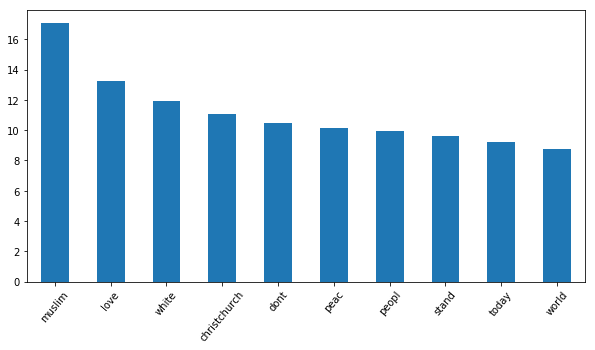

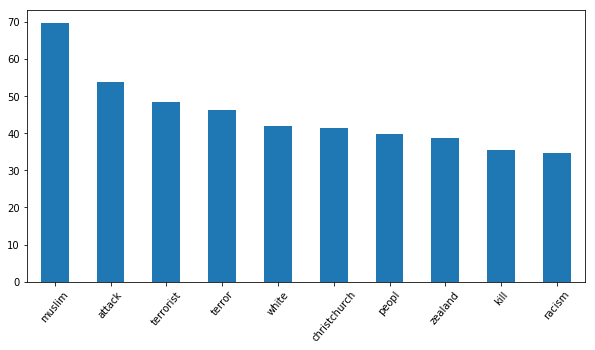

In [0]:
plt.figure(figsize=(10,5))
pos_allwords[:10].sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.show()

plt.figure(figsize=(10,5))
neg_allwords[:10].sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.show()

# Export Model

In [0]:
# untuk fungsi regex
import re

# untuk mengambil punctuation data
import string

# untuk analisis dan memanipulasi data
import pandas as pd

# Untuk encoding label
from sklearn.preprocessing import LabelEncoder

# Untuk tokenize 
from nltk.tokenize import word_tokenize

# Untuk stemming, lemmatize dan stopwords
from nltk.stem import PorterStemmer

# Untuk proses TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Untuk proses SMOTE
from imblearn.over_sampling import SMOTE

# Untuk algoritma SVM
from sklearn.svm import LinearSVC

# Untuk export model
import pickle

from imblearn import pipeline

# Define fungsi untuk clean tweet
def clean_tweet(tweet):
	# Case folding
	tweet = tweet.lower()

	# Cleansing (Remove URL)
	tweet = re.sub('http\S+|\S+co\S+', ' ', tweet)

	# Cleansing (Remove Mention)
	tweet = re.sub("@[A-Za-z0-9\S]+", "", tweet)

	# Cleansing (Remove Hastag)
	tweet = re.sub(r'#([^\s]+)', r'\1', tweet)

	# Cleansing (Convert Emoticon)
	emotion	= [emot.strip('\n').strip('\r') for emot in open('emotion.txt')]
	dic={}
	token = tweet.split()
	for i in emotion:
		(key,val)=i.split('\t')
		dic[str(key)]=val
	tweet = ' '.join(str(dic.get(word, word)) for word in token)

	# Cleansing (Remove Number and Punctuation)
	wrem_list = ('rt')
	exclude = set (string.punctuation)
	rem_list = []
	token = tweet.split()
	for w in token:
		if w not in wrem_list:
			for x in w:
				if x in exclude or x.isdigit():
					x=""
					rem_list.append(x)
				else:
					rem_list.append(x)
			rem_list.append(" ")
	tweet = "".join(rem_list)
	
	# Replace karakter berulang
	def hapus_katadouble(tweet):
		pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
		return pattern.sub(r"\1\1", tweet)  

	tweet=hapus_katadouble(tweet)
	tweet = re.sub('[\s]+|[, ]+', ' ', tweet.strip())
	return tweet

# Define fungsi untuk stemming
def preprocessing_en_stem(tweet):
	stemmer = PorterStemmer()

	# Masukkan stopword tambahan
	file = open('stop_tambah.txt')
	stoptambah = file.read()

	# Memecah kata menggunakan word_tokenize
	token_words = word_tokenize(clean_tweet(tweet))
	sentence = []
	for word in token_words:
		# kondisi untuk filter length dan stopwords tambahan
		if word not in stoptambah and len(word) > 1 and len(word) < 25:
			sentence.append(stemmer.stem(word))
	return sentence

# Read Dataset
print("Read Dataset")
#file_name = ('Dataset_islamophobia.csv')
#df= pd.read_csv(file_name)

# Encode Data Label
print("Encode Label")
le = LabelEncoder().fit(["Positive", "Negative"])
y = le.transform(df['Sentiment'])

# Melakukan proses TF-IDF
print("TF-IDF")
tfidfconverter = TfidfVectorizer(min_df=2, max_df=0.7, ngram_range=(1,3), stop_words=word_tokenize('english'), tokenizer= preprocessing_en_stem)
X_vect = tfidfconverter.fit_transform(df['Tweet']).toarray()
print(X_vect.shape)

# Penggunaan SMOTE
print("SMOTE")
sm_combine = SMOTE(sampling_strategy='minority',random_state=10)
X_vect,y = sm_combine.fit_sample(X_vect,y)

print("algoritma")
# Algoritma SVM
clr = LinearSVC(C=3.0)
clr.fit(X_vect,y)

clr = pipeline.make_pipeline(sm_combine,clr)

print(clr)

print("dump")
# Saving model to disk
pickle.dump(clr, open('model.pkl','wb'))

print("load")
# Loading model to compare the results
model = pickle.load( open('model.pkl','rb'))

print("predict")
tweet = "he is a good boy"
tweet = tfidfconverter.transform([tweet]).toarray()
print(model.predict(tweet))

!cp model.pkl /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/

Read Dataset
Encode Label
TF-IDF
(2657, 6950)
SMOTE
algoritma
Pipeline(memory=None,
         steps=[('smote',
                 SMOTE(k_neighbors=5, kind='deprecated',
                       m_neighbors='deprecated', n_jobs=1,
                       out_step='deprecated', random_state=10, ratio=None,
                       sampling_strategy='minority',
                       svm_estimator='deprecated')),
                ('linearsvc',
                 LinearSVC(C=3.0, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)
dump
load
predict
[1]


In [0]:
!pip list

Package                  Version              
------------------------ ---------------------
absl-py                  0.7.1                
alabaster                0.7.12               
albumentations           0.1.12               
altair                   3.2.0                
astor                    0.8.0                
astropy                  3.0.5                
atari-py                 0.1.15               
atomicwrites             1.3.0                
attrs                    19.1.0               
audioread                2.1.8                
autograd                 1.3                  
Babel                    2.7.0                
backcall                 0.1.0                
backports.tempfile       1.0                  
backports.weakref        1.0.post1            
beautifulsoup4           4.6.3                
bleach                   3.1.0                
blis                     0.2.4                
bokeh                    1.0.4                
boto         

# Testing dari Model yang telah disimpan

In [0]:
!ls

# Copy Model
!cp  /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/model.pkl /content/

dataminer_islamophobia_15Mar19.xlsx  gdrive
emotion.txt			     sample_data
export_data_islamophobia1.csv	     stop_tambah.txt
export_data_islamophobia2.csv


In [0]:
# load the model from disk
loaded_model = pickle.load( open('model.pkl','rb'))

# Test prediksi
review = "All those empty words and no mention of Islamophobia or white supremacy/white nationalism"
trans = gtrans_tweet_en(review)
print(trans)
review_vect = tfidfconverter.transform([trans]).toarray()
print(review_vect)
predmod = loaded_model.predict(review_vect)
print(predmod)
inv_tra = le.inverse_transform(predmod)
print(inv_tra)

All those empty words and no mention of Islamophobia or white supremacy/white nationalism
[[0. 0. 0. ... 0. 0. 0.]]
[0]
['Negative']


In [0]:
df_tfidf = pd.DataFrame(review_vect,columns=tfidfconverter.get_feature_names())
#display(df_tfidf)
words = df_tfidf.sum(axis=0)#.sort_values(ascending=False)
#display(words)
result = pd.DataFrame({'Count': words}).reset_index()#[:10].to_numpy()
result = result[result.Count >0].to_numpy()
result = ','.join(str(v) for v in result)

In [0]:
words

abandon                        0.0
abject                         0.0
ableism                        0.0
abolish                        0.0
abort                          0.0
abottabad                      0.0
abottabad pakistan             0.0
abottabad pakistan son         0.0
abroad                         0.0
abroad stand                   0.0
abroad stand stand             0.0
absolut                        0.0
absolut sicken                 0.0
absolut sicken islamophobia    0.0
absolv                         0.0
absurd                         0.0
abus                           0.0
abus drove                     0.0
abus independ                  0.0
abus muslim                    0.0
abus muslim attack             0.0
abus spider                    0.0
academ                         0.0
acceler                        0.0
accept                         0.0
accept foundat                 0.0
accept foundat premis          0.0
accept intoler                 0.0
accept intoler musli

In [0]:
print(result)

['empti' 0.44739989701259686],['islamophobia' 0.0681139454257528],['islamophobia white' 0.30646307298444286],['mention' 0.3427779554970097],['mention islamophobia' 0.4339760567736478],['mention islamophobia white' 0.5208914240821709],['nation' 0.29563660471297415],['white' 0.1916073723333875]


## Testing Script

In [0]:
from unidecode import unidecode

#tweet="      @Nama_dia_siapa    I don't ngga know 4u !!! 123 :thumbs_up: :) the               functions of this fan is great using doing nothing Real tragedy? \n9/11 was a horrible tragedy an"
#test ='nggak tau.. .. .! ! an as bc breitbart'
#test='This is how ISLAMophobia started. And truthfully please eradicate this kind of people. https://twitter.com/PrisonPlanet/status/1117919355617128448 … https://twitter.com/PrisonPlanet/status/1117918164262612993 …'
#test='Seeds Of Iblis"Islamophobia"\nイラクの反イスラムブラックメタル...'
#test='_of_essex postgrad is going back to their coun...'
#test= 'oh god here we go pushing islamophobia :^) :^)'
#tweet='Sangat penting utk mengetahui motif penembakan di Selandia Baru, karena dr motif itupula kita bs menilai apakah Islamophobia msh "happening" di dunia barat?? #Islamophobia #NewZealandTerroristAttack @Menlu_RI @Kemlu_RI'

#tweet='https://twitter.com/alexwickham/status/1107749752421134343 @Conservatives  +  ISLAMOPHOBIA   https://twitter.com/alexwickham/status/1107749752421134343 … Here is @SayeedaWarsi tonight condemning CCHQ for its lack of transparency. Real questions now over the Tory party’s complaints procedure. These people are only dealt with when we put them to CCHQ, and they won’t say…'
tweet = "when i was still in grade shoooool, we were taught in books to respect other people's belief, religion, tradition; culture innnnn general. the books we used greatly emphasized that. it brokeeeeeeee my heart when i heard the news that islamophobia killed 49 muslims, i give my condolences. sad"
#tweet="نیوزی لینڈ کی مساجد میں کربلا بپا کرکے اسمیں د"


print(tweet)
def hapus_katadouble(tweet):
    pattern = re.compile(r"(.)\1{1,}", re.DOTALL)
    return pattern.sub(r"\1\1", tweet)
  
tweet=hapus_katadouble(tweet)
                         
#tweet=gtrans_tweet_en(tweet)
print(tweet)
#tweet=clean_tweet(tweet)
#print(clean_tweet(tweet))
#print(preprocessing_en(tweet))
#print(gtrans_tweet_en(preprocessing_en(clean_tweet(test))))
#print(sentiment_Vader(tweet))

when i was still in grade shoooool, we were taught in books to respect other people's belief, religion, tradition; culture innnnn general. the books we used greatly emphasized that. it brokeeeeeeee my heart when i heard the news that islamophobia killed 49 muslims, i give my condolences. sad
when i was still in grade shool, we were taught in books to respect other people's belief, religion, tradition; culture inn general. the books we used greatly emphasized that. it brokee my heart when i heard the news that islamophobia killed 49 muslims, i give my condolences. sad


In [0]:
# Test emoticon and url
#tweet = (' RT @bayhaqy Python is :thumbs_up: :) #nice https://detik.com ')
#tweet = (':thumbs_up:')
#tweet = ('namanya gue adalah :bayhaqy ? & yang ... ...... .,. ,. ., :)')
#tweet = ('ḊḕḀṙ ₲ØĐ, p̾l̾e̾a̾s̾e ḧḕḶṖ ṁḕ ẇḭṮḧ ṮḧḭṠ ḀḶḀẏḕṙṠ')
tweet = ('Doing Pamela Geller: “Islamophobia” is “a device 2019 - for imposing sharia”\xa0(Video) https://boudicabpi001.wordpress.com/2019/04/15/pamela-geller-islamophobia-is-a-device-for-imposing-sharia-video/\xa0…')
#tweet = ('Seeds Of Iblis"Islamophobia"\nイラクの反イスラムブラックメタルバンド。とにかくオリエンタルな雰囲気が最大の特徴！後半のお経パートは怪しさ満点でいい感じですね。\nhttps://m.youtube.com/watch?v=YC64zEtvqTg\xa0…')
print(tweet)
tweet1=tweet.split(' ')
print(tweet1)

tweet3=word_tokenize(tweet)
print(tweet3)

print(tokenize(tweet))
tweet4=clean_tweet(tweet)
print(preprocessing_id(tweet4))

#senti = sentiment_analysis_en(senti)
#print(senti)


In [0]:
#print(stopword_tweet_en(tweet))
cat -n /root/nltk_data/corpora/stopwords/bay_indo|head -10

In [0]:
#print(stopword_tweet_en(tweet))
#cat -n /root/nltk_data/corpora/stopwords/english|tail -10
#!ls /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'
#!cp /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/bay_indo /root/nltk_data/corpora/stopwords/
# Copy kamus stopword indonesia ke nltk
#!cp /root/nltk_data/corpora/stopwords/english /content/gdrive/My\ Drive/'Colab Notebooks'/'Sentiment Analysis'/
#!ls /root/nltk_data/corpora/stopwords/
ls

In [0]:
#!grep -iRl "sastrawi" /etc/
#!find / -iname "sastrawi"
ls /usr/local/lib/python3.6/dist-packages/Sastrawi/Stemmer/

In [0]:
# Example Translator with translated.net
for twit in data['Tweets'].head(2):
  print (twit)
  #print (type(twit))
  #print (type(tweet))
  tweeet = translate_tweet(twit)
  print (tweeet)
  #print (type(tweeet))
  tweet = sentiment_analysis_Vader(tweeet)
  print (tweet)

In [0]:
# Example translate with google translated
for twit in data['Tweets'].head(2):
  print (twit)
  #print (type(twit))
  tweet = clean_tweet(twit)
  print (tweet)
  #print (type(tweet))
  tweet = gtrans_tweet_en(twit)
  print (tweet)
  #print (type(tweet))
  tweet = sentiment_analysis_Vader(tweet)
  print (tweet) to